---
title: Homework 2
author: "Group 5: Yilin Yang, Huiting Song, Kangheng Liu"
format:
  html:
    toc: true
    numbered: true
    toc-depth: 4
    self-contained: true
---

Please use jupyter notebook to implement the following structures. You will upload a Jupyter Notebook and an HTML or a PDF file (exported from the notebook) to the canvas portal. There is no restriction on what IDE to use, but a cloud IDE like Google Collab or AWS Sagemaker would be your best choice if you have a low-power/configuration computer. All the assignments are graded holistically. All assignments in the class are group assignments (if you prefer, you can choose to work independently).

This assignment will be graded out of 75 points. Each assignment submission page lists assignment open and close dates with grace periods (48 hours). They are also listed on the syllabus.

Since Blockchain is open-sourced, you will find most of the code online with a complete solution to most assignments. Please refrain from copy-pasting. The goal is to learn to build one from scratch to understand the technology. I will keep an eye on the submissions. Please list the source after the code to avoid plagiarism and copying issues.

The entire assignment is recorded and posted on Canvas under Panopto. You should go over the video and modify the code accordingly.

### 1       Importing data and packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from requests import Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects, HTTPError
import json
import os 
import seaborn as sns 
from datetime import datetime


In [2]:
plt.style.use('bmh')

### 2       Gather Coin token ID information from Coinmarket, Binance, or Coinbase.
You will need to search on any of the three websites to get the token IDs. The video shows how to do it through Binance and coin market cap. A slight difference between the Binance token and the coin market token is that the Binance token adds BUSD or USDT at the end, while the CoinMarket token does not. For example, Bitcoin is represented as BTC in CoinMarket and BTCBUSD or BTCUSDT in Binance. This represents the currency conversion to a stablecoin instead of a fiat currency.

For the sake of this bit, you can choose any 30 cryptocurrencies except Bitcoin and Ethereum. Here are the categories to select from

High market cap group - this will include the most widely traded coins. We will use the top 5 coins, namely, Bitcoin (BTC-USD), Ethereum (ETH-USD), Litecoin (LTC-USD), Teather (USDT), and BNB (BNB-USD).
Mid-market cap group will include coins with a market cap between 1 billion and 20 billion. We will use the top 5 coins, namely, Cardano (ADA-USD), Polygon (MATIC-USD), Dogecoin (DOGE-USD), Ripple (XRP-USD), and Binance USD (BUSD).
The low market cap group will include coins with a market cap between 100 million and 1 billion. We will use the top 20 coins.
Make sure to list the ticker ids in a list of strings

#### 2.1        Getting Data From Binance
Create a function that takes ticker interval, start_time, and end_time as input. We want to get all the data for the selected tickers and save them in data chosen frames. There is a way to automate this by using a function as well.

For each coin/token, you will get a dataframe of daily movements from start to end. The date and time are set as the index. Close, Symbol, and index are the most critical columns, and we want to subset them in a" coins" dataframe for all the coins.
Rename close to "Coinname_closeprice." Replace the coin name with the name of the coin and token id.

In [3]:
import requests

# Fetch the list of cryptocurrencies
url = 'https://api.coingecko.com/api/v3/coins/markets'
params = {
    'vs_currency': 'usd',
    'order': 'market_cap_desc',
    'per_page': 100,
    'page': 1,
}

response = requests.get(url, params=params)
coins = response.json()

# Sort the coins by market capitalization in descending order
coins.sort(key=lambda x: x['market_cap'], reverse=True)

# Define the groups
high_market_cap_group = []
mid_market_cap_group = []
low_market_cap_group = []

# Iterate through the coins and categorize them
for coin in coins:
    ticker_id = coin['id']
    market_cap = coin['market_cap']
    
    
    # High Market Cap Group
    if len(high_market_cap_group) < 5 and market_cap >= 20_000_000_000:
        high_market_cap_group.append(ticker_id)
        
    # Mid Market Cap Group
    elif len(mid_market_cap_group) < 5 and 1_000_000_000 <= market_cap < 20_000_000_000:
        mid_market_cap_group.append(ticker_id)
    
    # Low Market Cap Group
    elif len(low_market_cap_group) < 20 and 100_000_000 <= market_cap < 1_000_000_000:
        low_market_cap_group.append(ticker_id)

# Print the resulting groups
print("High Market Cap Group:", high_market_cap_group)
print("Mid Market Cap Group:", mid_market_cap_group)
print("Low Market Cap Group:", low_market_cap_group)




High Market Cap Group: ['bitcoin', 'ethereum', 'tether', 'binancecoin', 'ripple']
Mid Market Cap Group: ['staked-ether', 'solana', 'cardano', 'dogecoin', 'tron']
Low Market Cap Group: ['rocket-pool-eth', 'the-graph', 'algorand', 'whitebit', 'usdd', 'blockstack', 'immutable-x', 'xdce-crowd-sale', 'havven', 'elrond-erd-2', 'frax', 'eos', 'theta-token', 'injective-protocol', 'tezos', 'the-sandbox', 'bitget-token', 'axie-infinity', 'bitcoin-cash-sv', 'radix']


#### 2.2        Combining the dataframe
The updated dataframe should have the index and close price of all the coins of interest. We will use this to calculate the efficient frontier for the portfolio.

In [4]:
import requests
import pandas as pd
from datetime import datetime
import time

# Your predefined groups and codes remain unchanged

# Define the function to fetch historical data
def fetch_historical_data(coin_id, from_timestamp, to_timestamp, vs_currency='usd'):
    url = f'https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart/range'
    attempts = 0
    max_attempts = 5
    wait_time = 10
    
    while attempts < max_attempts:
        response = requests.get(url, params={'vs_currency': vs_currency, 'from': from_timestamp, 'to': to_timestamp})
        if response.status_code == 200:
            return response.json()
        elif response.status_code == 429:
            print(f"Hit rate limit fetching data for {coin_id}, retrying in {wait_time} seconds...")
            time.sleep(wait_time)
            attempts += 1
            wait_time *= 2
        else:
            print(f"Failed to retrieve data for {coin_id}. Error code: {response.status_code}")
            return None
    
    print(f"Failed to retrieve data for {coin_id} after {max_attempts} attempts.")
    return None

# Get the Unix timestamp for 2022-09-27
from_timestamp = int(datetime.strptime('2022-09-27', '%Y-%m-%d').timestamp())

# Get the Unix timestamp for 2023-09-27
to_timestamp = int(datetime.strptime('2023-09-27', '%Y-%m-%d').timestamp())


# Adjusting the wait time between API calls to avoid rate limiting
time_between_calls = 60  # seconds

high_historical_data = {}

#Generate high market cap group first
for coin_id in high_market_cap_group:
    time.sleep(time_between_calls)  # adding sleep to avoid hitting rate limit
    
    data = fetch_historical_data(coin_id, from_timestamp, to_timestamp)
    if data and 'prices' in data and data['prices']:
        # Continue only if there is valid data
        df = pd.DataFrame(data['prices'], columns=['timestamp', f'{coin_id}_closeprice'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)
        high_historical_data[coin_id] = df
    else:
        print(f"No valid data available for {coin_id} in the given date range.")


# Combining all coin dataframes into one
if high_historical_data:
    coins_df = pd.concat(high_historical_data.values(), axis=1)
    print(coins_df.head())  # Print the first 5 rows of the resultant dataframe
    coins_df.to_csv('coin_prices.csv', index=True)
else:
    print("No valid historical data available for any coin in the given date range.")


# Combining all coin dataframes into one
high_coins_df = pd.concat(high_historical_data.values(), axis=1)

print(high_coins_df.head())  # Print the first 5 rows of the resultant dataframe


            bitcoin_closeprice  ethereum_closeprice  tether_closeprice  \
timestamp                                                                
2022-09-28        19116.331161          1331.150177           1.000675   
2022-09-29        19444.787771          1340.023059           1.001686   
2022-09-30        19563.765162          1335.738971           0.999983   
2022-10-01        19476.926596          1329.146032           1.000868   
2022-10-02        19314.463835          1311.263324           1.000526   

            binancecoin_closeprice  ripple_closeprice  
timestamp                                              
2022-09-28              272.550204           0.449739  
2022-09-29              281.358161           0.452320  
2022-09-30              283.748723           0.485497  
2022-10-01              284.007432           0.480186  
2022-10-02              282.869812           0.474961  
            bitcoin_closeprice  ethereum_closeprice  tether_closeprice  \
timestamp      

In [5]:
# Generate mid market cap group
mid_historical_data = {}

for coin_id in mid_market_cap_group:
    time.sleep(time_between_calls)  # adding sleep to avoid hitting rate limit
    
    data = fetch_historical_data(coin_id, from_timestamp, to_timestamp)
    if data and 'prices' in data and data['prices']:
        # Continue only if there is valid data
        df = pd.DataFrame(data['prices'], columns=['timestamp', f'{coin_id}_closeprice'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)
        mid_historical_data[coin_id] = df
    else:
        print(f"No valid data available for {coin_id} in the given date range.")


# Combining all coin dataframes into one
if mid_historical_data:
    coins_df = pd.concat(mid_historical_data.values(), axis=1)
    print(coins_df.head())  # Print the first 5 rows of the resultant dataframe
    coins_df.to_csv('coin_prices.csv', index=True)
else:
    print("No valid historical data available for any coin in the given date range.")


# Combining all coin dataframes into one
mid_coins_df = pd.concat(mid_historical_data.values(), axis=1)

print(mid_coins_df.head())  # Print the first 5 rows of the resultant dataframe

            staked-ether_closeprice  solana_closeprice  cardano_closeprice  \
timestamp                                                                    
2022-09-28              1327.688712          32.766122            0.442535   
2022-09-29              1335.960919          33.303300            0.438446   
2022-09-30              1330.090885          33.935996            0.437977   
2022-10-01              1326.804171          33.249664            0.434426   
2022-10-02              1308.867529          32.455791            0.430908   

            dogecoin_closeprice  tron_closeprice  
timestamp                                         
2022-09-28             0.060660         0.059472  
2022-09-29             0.060824         0.059755  
2022-09-30             0.060749         0.061011  
2022-10-01             0.061720         0.061151  
2022-10-02             0.060680         0.060523  
            staked-ether_closeprice  solana_closeprice  cardano_closeprice  \
timestamp         

In [6]:
# Generate low market cap group
low_historical_data = {}

for coin_id in low_market_cap_group:
    time.sleep(time_between_calls)  # adding sleep to avoid hitting rate limit
    
    data = fetch_historical_data(coin_id, from_timestamp, to_timestamp)
    if data and 'prices' in data and data['prices']:
        # Continue only if there is valid data
        df = pd.DataFrame(data['prices'], columns=['timestamp', f'{coin_id}_closeprice'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)
        low_historical_data[coin_id] = df
    else:
        print(f"No valid data available for {coin_id} in the given date range.")


# Combining all coin dataframes into one
if low_historical_data:
    coins_df = pd.concat(low_historical_data.values(), axis=1)
    print(coins_df.head())  # Print the first 5 rows of the resultant dataframe
    coins_df.to_csv('coin_prices.csv', index=True)
else:
    print("No valid historical data available for any coin in the given date range.")


# Combining all coin dataframes into one
low_coins_df = pd.concat(low_historical_data.values(), axis=1)

print(low_coins_df.head())  # Print the first 5 rows of the resultant dataframe

            rocket-pool-eth_closeprice  the-graph_closeprice  \
timestamp                                                      
2022-09-28                 1383.803801              0.099724   
2022-09-29                 1393.530770              0.099169   
2022-09-30                 1382.906860              0.099304   
2022-10-01                 1382.109407              0.098991   
2022-10-02                 1364.880039              0.098027   

            algorand_closeprice  whitebit_closeprice  usdd_closeprice  \
timestamp                                                               
2022-09-28             0.354013             4.053502         1.001474   
2022-09-29             0.350463             5.878442         1.002629   
2022-09-30             0.355148             5.879988         1.003861   
2022-10-01             0.353054            10.382280         1.001534   
2022-10-02             0.355094            10.780270         0.999831   

            blockstack_closeprice  immu

In [8]:
# Combining all three dataframes into one
combined_df = pd.concat([high_coins_df, mid_coins_df, low_coins_df], axis=1)

# Printing the first 5 rows of the resultant dataframe
print(combined_df.head())

# Save the combined dataframe to a CSV file
combined_df.to_csv('combined_coin_prices.csv', index=True)

            bitcoin_closeprice  ethereum_closeprice  tether_closeprice  \
timestamp                                                                
2022-09-28        19116.331161          1331.150177           1.000675   
2022-09-29        19444.787771          1340.023059           1.001686   
2022-09-30        19563.765162          1335.738971           0.999983   
2022-10-01        19476.926596          1329.146032           1.000868   
2022-10-02        19314.463835          1311.263324           1.000526   

            binancecoin_closeprice  ripple_closeprice  \
timestamp                                               
2022-09-28              272.550204           0.449739   
2022-09-29              281.358161           0.452320   
2022-09-30              283.748723           0.485497   
2022-10-01              284.007432           0.480186   
2022-10-02              282.869812           0.474961   

            staked-ether_closeprice  solana_closeprice  cardano_closeprice  \
tim

### 3 Calculating the Efficient Frontier
To calculate an efficient frontier, we will need to calculate each coin's means, standard deviations, and covariances.

1. Calculate the mean of the dataframe generated in 2.2 using pd.df.mean() method
2. Calculate the covariance matrix of the dataframe generated in 2.2 using pd.df.cov() method
3. Use the function in the video to generate a complete crypto portfolio for $10,000.


In [ ]:
# read the csv file saved in 2.2
combined_df = pd.read_csv("./combined_coin_prices.csv")

In [ ]:
# 1. Calculate the mean of the dataframe generated in 2.2 using pd.df.mean() method
combined_df.set_index('timestamp', inplace=True) # make the timestamp column as index
mean_daily_returns = combined_df.pct_change().mean()
print("The mean of each coin is:")
print(mean_daily_returns)

The mean of each coin is:
bitcoin_closeprice               0.001166
ethereum_closeprice              0.000925
tether_closeprice               -0.000002
binancecoin_closeprice          -0.000305
ripple_closeprice                0.001410
staked-ether_closeprice          0.000938
solana_closeprice                0.000086
cardano_closeprice              -0.001036
dogecoin_closeprice              0.000992
tron_closeprice                  0.001225
rocket-pool-eth_closeprice       0.001053
the-graph_closeprice             0.001065
algorand_closeprice             -0.002722
whitebit_closeprice              0.001991
usdd_closeprice                 -0.000005
blockstack_closeprice            0.002582
immutable-x_closeprice           0.000826
xdce-crowd-sale_closeprice       0.002245
havven_closeprice                0.001014
elrond-erd-2_closeprice         -0.001257
frax_closeprice                  0.000006
eos_closeprice                  -0.001343
theta-token_closeprice          -0.000777
injectiv

In [ ]:
# 2. Calculate the covariance matrix of the dataframe generated in 2.2 using pd.df.cov() method
cov_matrix = combined_df.pct_change().cov()
print("The covariance matrix for each coin is:")
print(cov_matrix)

The covariance matrix for each coin is:
                               bitcoin_closeprice  ethereum_closeprice  \
bitcoin_closeprice                       0.000599             0.000642   
ethereum_closeprice                      0.000642             0.000862   
tether_closeprice                        0.000004             0.000006   
binancecoin_closeprice                   0.000496             0.000605   
ripple_closeprice                        0.000624             0.000856   
staked-ether_closeprice                  0.000647             0.000866   
solana_closeprice                        0.001003             0.001250   
cardano_closeprice                       0.000623             0.000813   
dogecoin_closeprice                      0.000656             0.000907   
tron_closeprice                          0.000351             0.000433   
rocket-pool-eth_closeprice               0.000648             0.000870   
the-graph_closeprice                     0.000841             0.001051  

In [ ]:
# 3. Use the function in the video to generate a complete crypto portfolio for $10,000.
import numpy as np

def portfolio_statistics(coins, number_portfolios, mean_daily_returns, cov_matrix):
    coins = coins.columns.tolist()
    results_temp = np.zeros((4 + len(coins) - 1, number_portfolios))

    for i in range(number_portfolios):
        weights = np.array(np.random.random(30))
        weights /= np.sum(weights)
        portfolio_return = np.sum(mean_daily_returns * weights) * 252
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
        risk_free_return = 0.0139
        results_temp[0,i] = portfolio_return
        results_temp[1,i] = portfolio_std_dev
        results_temp[2,i] = (results_temp[0,i] - risk_free_return) / results_temp[1,i]

        for j in range(len(weights)):
            results_temp[j+3,i] = weights[j]

    results_df = pd.DataFrame(results_temp.T, columns=['returns','stdev','sharpe'] + coins)

    return results_df

In [ ]:
crypto_results = portfolio_statistics(combined_df,10000,mean_daily_returns,cov_matrix)
crypto_results.head(15)

,returns,stdev,sharpe,bitcoin_closeprice,ethereum_closeprice,tether_closeprice,binancecoin_closeprice,ripple_closeprice,staked-ether_closeprice,solana_closeprice,...,frax_closeprice,eos_closeprice,theta-token_closeprice,injective-protocol_closeprice,tezos_closeprice,the-sandbox_closeprice,bitget-token_closeprice,axie-infinity_closeprice,bitcoin-cash-sv_closeprice,radix_closeprice
0,0.088775,0.431770,0.173414,0.019117,0.057938,0.058408,0.018978,0.038161,0.034793,0.012725,...,0.057034,0.043219,0.003224,0.022228,0.001554,0.021973,0.009647,0.042493,0.009531,0.002092
1,0.142763,0.445041,0.289553,0.018531,0.015071,0.030280,0.019292,0.021130,0.042786,0.010033,...,0.023837,0.045279,0.054832,0.036936,0.041842,0.051120,0.032419,0.003623,0.015476,0.036709
2,0.109613,0.430947,0.222099,0.012449,0.014486,0.029399,0.034085,0.049059,0.019393,0.034730,...,0.028555,0.044157,0.044101,0.053458,0.043366,0.031652,0.034887,0.030555,0.034994,0.002848
3,0.139527,0.446558,0.281323,0.035296,0.001065,0.030392,0.011647,0.014072,0.056628,0.072175,...,0.032069,0.015554,0.011612,0.040839,0.050510,0.066377,0.074903,0.041275,0.069795,0.051043
4,0.142613,0.426712,0.301639,0.059811,0.049004,0.015255,0.043186,0.056074,0.020812,0.013606,...,0.031404,0.040194,0.016055,0.052473,0.026985,0.056382,0.039065,0.051517,0.001447,0.036247
5,0.157294,0.446237,0.321340,0.024375,0.035970,0.039453,0.035850,0.005957,0.003782,0.039799,...,0.053082,0.056946,0.003227,0.057496,0.065487,0.024895,0.043420,0.040364,0.065015,0.046339
6,0.179374,0.424706,0.389621,0.003580,0.004462,0.038863,0.045868,0.033982,0.055724,0.006085,...,0.057990,0.051582,0.034644,0.059823,0.004534,0.053367,0.014696,0.041503,0.054147,0.058473
7,0.138769,0.441847,0.282608,0.006056,0.034795,0.003037,0.000638,0.037411,0.013408,0.040998,...,0.072835,0.021483,0.048343,0.037627,0.030109,0.063091,0.018683,0.075201,0.020969,0.013669
8,0.171171,0.464980,0.338232,0.048832,0.042310,0.001141,0.036711,0.027562,0.010149,0.051594,...,0.012379,0.021368,0.008836,0.057318,0.072679,0.001852,0.036538,0.029720,0.068099,0.024383
9,0.144624,0.420776,0.310672,0.042360,0.054045,0.044748,0.052884,0.022466,0.005275,0.039587,...,0.013695,0.011854,0.043242,0.036303,0.053445,0.015736,0.024117,0.028978,0.038491,0.051365


### 4 Locate the Best portfolios

The percentages returned from the best portfolio search represent the total assets added to each coin from the $10,000.

#### 4.1 Locate the position of the portfolio with the highest Sharpe Ratio


In [ ]:
def max_sharpe_ratio(results_df):
    # locate portfolio with highest Sharpe Ratio
    return results_df.iloc[results_df["sharpe"].idxmax()]

crypto_max_sharpe_portfolio = max_sharpe_ratio(crypto_results)
print(crypto_max_sharpe_portfolio)

returns                          0.288049
stdev                            0.421558
sharpe                           0.650323
bitcoin_closeprice               0.059961
ethereum_closeprice              0.060320
tether_closeprice                0.041207
binancecoin_closeprice           0.001416
ripple_closeprice                0.022565
staked-ether_closeprice          0.048877
solana_closeprice                0.000108
cardano_closeprice               0.035055
dogecoin_closeprice              0.039438
tron_closeprice                  0.052320
rocket-pool-eth_closeprice       0.046897
the-graph_closeprice             0.064549
algorand_closeprice              0.007187
whitebit_closeprice              0.064820
usdd_closeprice                  0.013804
blockstack_closeprice            0.069823
immutable-x_closeprice           0.073017
xdce-crowd-sale_closeprice       0.011530
havven_closeprice                0.016835
elrond-erd-2_closeprice          0.012015
frax_closeprice                  0

#### 4.2 Locate the portfolio with the lowest volatility


In [ ]:
def min_volatility(results_df):
    # locate portfolio with lowest volatility
    return results_df.iloc[results_df['stdev'].idxmin()]
                                      
crypto_min_vol_portfolio = min_volatility(crypto_results)
print(crypto_min_vol_portfolio)

returns                          0.139099
stdev                            0.345366
sharpe                           0.362511
bitcoin_closeprice               0.013645
ethereum_closeprice              0.077222
tether_closeprice                0.021567
binancecoin_closeprice           0.046741
ripple_closeprice                0.015207
staked-ether_closeprice          0.011056
solana_closeprice                0.014249
cardano_closeprice               0.016948
dogecoin_closeprice              0.015322
tron_closeprice                  0.068957
rocket-pool-eth_closeprice       0.036728
the-graph_closeprice             0.010403
algorand_closeprice              0.004879
whitebit_closeprice              0.036529
usdd_closeprice                  0.075249
blockstack_closeprice            0.038320
immutable-x_closeprice           0.002312
xdce-crowd-sale_closeprice       0.025795
havven_closeprice                0.040845
elrond-erd-2_closeprice          0.061768
frax_closeprice                  0

#### 4.3 Plot the efficiant portoflio

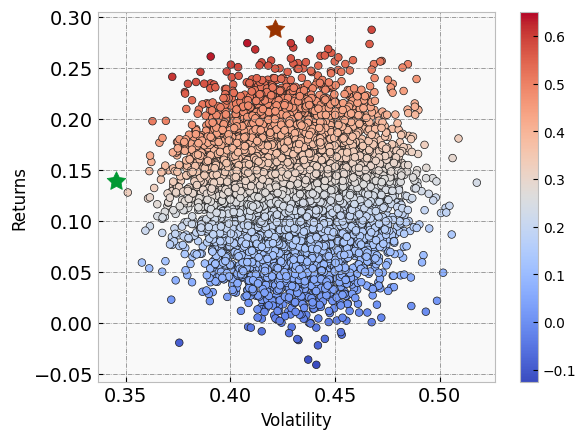

In [ ]:
def plot_graph(results_df, max_sharpe_port, min_vol_port):
    ax = results_df.plot(kind = 'scatter', x = 'stdev', y = 'returns', s = 30, c=results_df.sharpe, cmap='coolwarm',edgecolors=' .1')
    ax.grid(color = '#777777', linestyle = '-.', linewidth = 0.5)
    ax.set_facecolor('#f9f9f9')
    ax.set_xlabel('Volatility')
    ax.set_ylabel('Returns')
    ax.tick_params(labelsize = 14)
    
    # # plot red star to highlight the position of the portfolio with the highest Sharpe Ratio
    ax.scatter(max_sharpe_port[1], max_sharpe_port[0], marker=(5, 1, 0), color='#993300', s=200)
    
    # # plot green star to highlight the position of the minimum variance portfolio
    ax.scatter(min_vol_port[1], min_vol_port[0], marker=(5, 1, 0), color='#009933', s=200)

plot_graph(crypto_results, crypto_max_sharpe_portfolio, crypto_min_vol_portfolio)
plt.show()